In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import random
from torch import optim
import matplotlib.pyplot as plt
from typing import List
from utils import *
from torch.utils.data import Dataset, DataLoader, RandomSampler
import tqdm
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


cuda


In [70]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, d_internal, init=False):
        """
        :param d_model: The dimension of the inputs and outputs of the layer (note that the inputs and outputs
        have to be the same size for the residual connection to work)
        :param d_internal: The "internal" dimension used in the self-attention computation. Your keys and queries
        should both be of this length.
        """
        super().__init__()
        """
        self.W_Q = torch.tensor(np.random.random([d_model, d_internal]), dtype=torch.float64)
        self.W_K = torch.tensor(np.random.random([d_model, d_internal]), dtype=torch.float64)
        self.W_V = torch.tensor(np.random.random([d_model, d_model]), dtype=torch.float64)
        """
        self.W_Q = torch.nn.Linear(d_model, d_internal, False)
        self.W_K = torch.nn.Linear(d_model, d_internal, False)
        self.W_V = torch.nn.Linear(d_model, d_model, False)

        if init:
            # print(*self.W_Q.weight.data.shape)
            self.W_Q.weight.data = torch.eye(*self.W_Q.weight.data.shape)
            self.W_K.weight.data = torch.eye(*self.W_K.weight.data.shape)
            self.W_V.weight.data = torch.eye(*self.W_V.weight.data.shape)
                

        self.SoftMax = torch.nn.Softmax(dim=-1)

        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(d_model, d_model)
        )
        self.d_model = d_model
        self.d_internal = d_internal

        self.double()


        #raise Exception("Implement me")

    def forward(self, input_vecs):
        """
        Q = torch.matmul( input_vecs, self.W_Q)
        K = torch.matmul(input_vecs, self.W_K)
        V = torch.matmul(input_vecs, self.W_V )
        """
        Q = self.W_Q(input_vecs)
        K = self.W_K(input_vecs)
        V = self.W_V(input_vecs)


  
        Q = torch.matmul(Q, torch.transpose(K, -2, -1))

        Q = Q / torch.sqrt(torch.tensor(self.d_model)) 
        Attn = self.SoftMax(Q)
        a = torch.matmul(Attn, V)

        a = a + input_vecs

        output = self.FFN(a) + a

        
        return output, Attn

        raise Exception("Implement me")


# Implementation of positional encoding that you can use in your network
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, num_positions: int=20, batched=False):
        """
        :param d_model: dimensionality of the embedding layer to your model; since the position encodings are being
        added to character encodings, these need to match (and will match the dimension of the subsequent Transformer
        layer inputs/outputs)
        :param num_positions: the number of positions that need to be encoded; the maximum sequence length this
        module will see
        :param batched: True if you are using batching, False otherwise
        """
        super().__init__()
        # Dict size
        self.emb = nn.Embedding(num_positions, d_model)
        self.batched = batched
        self.d_model = d_model
        self.num_positions = num_positions

        self.sinu = torch.zeros((num_positions, d_model)).to(DEVICE)

        for pos in range(num_positions):
            for m in range(d_model):
                if m%2 == 0:
                    self.sinu[pos][m] += torch.sin(torch.tensor(pos/(10000**((2*m)/d_model))))
                else:
                    self.sinu[pos][m] += torch.cos(torch.tensor(pos/(10000**((2*m)/d_model))))

        #self.sinu = torch.tensor(self.sinu)

    # def change_np(self, np):
    #     if np == self.num_positions:
    #         return
        
    #     self.num_positions = np
    #     self.sinu = torch.zeros((np, self.d_model))
    #     for pos in range(self.num_positions):
    #         for m in range(self.d_model):
    #             if m%2 == 0:
    #                 self.sinu[pos][m] += torch.sin(torch.tensor(pos/(10000**((2*m)/self.d_model))))
    #             else:
    #                 self.sinu[pos][m] += torch.cos(torch.tensor(pos/(10000**((2*m)/self.d_model))))

    def forward(self, x):
        """
        :param x: If using batching, should be [batch size, seq len, embedding dim]. Otherwise, [seq len, embedding dim]
        :return: a tensor of the same size with positional embeddings added in
        """

        # Second-to-last dimension will always be sequence length
        # input_size = x.shape[-2]
        # indices_to_embed = torch.tensor(np.asarray(range(0, input_size))).type(torch.LongTensor)
        if self.batched:
            # Use unsqueeze to form a [1, seq len, embedding dim] tensor -- broadcasting will ensure that this
            # gets added correctly across the batch

            for b in range(x.shape[0]):
                x[b] += self.sinu
            return x 
        else:
            return x + self.sinu


TODO: test with various positional embeddings

In [77]:
class LetterCountingExample(object):
    def __init__(self, input: str, output: np.array, vocab_index: Indexer):
        self.input = input
        self.input_indexed = np.array([vocab_index.index_of(ci) for ci in input])
        self.input_tensor = torch.LongTensor(self.input_indexed)
        self.output = output
        self.output_tensor = torch.LongTensor(self.output)


class Transformer(nn.Module):
    def __init__(self, vocab_size, num_positions, d_model, d_internal, num_classes, num_layers, init=False, **args):
        """
        :param vocab_size: vocabulary size of the embedding layer
        :param num_positions: max sequence length that will be fed to the model; should be 20
        :param d_model: see TransformerLayer
        :param d_internal: see TransformerLayer
        :param num_classes: number of classes predicted at the output layer; should be 3
        :param num_layers: number of TransformerLayers to use; can be whatever you want
        """ 
        super().__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.d_internal = d_internal
        

        #self.tformer = []
        #for i in range(num_layers):
        #    self.tformer.append(TransformerLayer(d_model, d_internal))

        self.tformer = TransformerLayer(d_model, d_internal, init)
        #self.tformer1 = TransformerLayer(d_model, d_internal)
        self.Softmax = torch.nn.LogSoftmax(dim=-1)
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_internal),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(d_internal, num_classes)
        )
        self.b = False
        self.penc = PositionalEncoding(d_model=d_model, num_positions=num_positions, batched=self.b)
        self.embed = torch.nn.Embedding(vocab_size, d_model)

        self.double()

        #raise Exception("Implement me")

    def extrap(self, model, method='double'):
        if method == 'double':
            d_m = self.d_model
            d_i = d_m // 2 # = self.d_internal
            z = torch.zeros(d_m, d_i, dtype=float)
            j = 0

            for i in range(0, d_m-1, 2):
                z[i][j] = 1
                z[i+1][j] = 1
                j += 1

            z1 = torch.zeros(d_i, d_i//2, dtype=float)
            j = 0
            for i in range(0, d_i-1, 2):    
                z1[i][j] = 1
                z1[i+1][j] = 1
                j += 1

            Q = torch.matmul(z, torch.transpose(model.tformer.W_Q.weight.data, -1, -2))
            Q = torch.matmul(Q, torch.transpose(z1, -1,-2))
            self.tformer.W_Q.weight.data = torch.transpose(Q, -1, -2)

            K = torch.matmul(z, torch.transpose(model.tformer.W_K.weight.data, -1, -2))
            K = torch.matmul(z1, torch.transpose(K, -1, -2))
            self.tformer.W_K.weight.data = K

            V = torch.matmul(z, torch.transpose(model.tformer.W_V.weight.data, -1, -2))
            V = torch.matmul(z, torch.transpose(V,-1,-2))
            self.tformer.W_V.weight.data = torch.transpose(V, -1, -2)

        if method == 'onehot':
            # for one hot we simply add the corresponding one hot vector to the dimensions of the vector

            Q = model.tformer.W_Q.weight.data
            z = torch.zeros((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            # TODO: randn might be too random, try lowering standard dev and retry
            # z = torch.randn((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            Q = torch.cat((Q,z), dim=0)
            z = torch.zeros((self.d_model - model.d_model, self.d_model - model.d_model)).to(DEVICE)
            print(Q.shape)
            print(z.shape)
            # z = torch.randn((self.d_model - model.d_model, self.d_model - model.d_model)).to(DEVICE)
            Q = torch.cat((Q,z), dim=-1)
            for i in range(self.d_internal):
                Q[i][i] = 1 if Q[i][i] == 0 else Q[i][i]
            

            V = model.tformer.W_V.weight.data
            z = torch.zeros((self.d_model - model.d_model, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_model - model.d_model, model.tformer.d_model)).to(DEVICE)
            V = torch.cat((V,z), dim=0)
            z = torch.zeros((self.d_model, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_model, model.tformer.d_model)).to(DEVICE)
            V = torch.cat((V,z), dim=-1)
            for i in range(self.d_model):
                V[i][i] = 1 if V[i][i] == 0 else V[i][i]

            K = model.tformer.W_K.weight.data
            z = torch.zeros((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            K = torch.cat((K,z), dim=0)
            z = torch.zeros((self.tformer.d_internal, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.tformer.d_internal, model.tformer.d_model)).to(DEVICE)
            K = torch.cat((K,z), dim=-1)
            for i in range(self.d_internal):
                K[i][i] = 1 if K[i][i] == 0 else K[i][i]


            self.tformer.W_Q.weight.data = Q
            self.tformer.W_K.weight.data = K
            self.tformer.W_V.weight.data = V



    def forward(self, indices):
        """

        :param indices: list of input indices
        :return: A tuple of the softmax log probabilities (should be a 20x3 matrix) and a list of the attention
        maps you use in your layers (can be variable length, but each should be a 20x20 matrix)
        """
        t = self.embed(indices)
        t = self.penc(t)
        t = t.to(torch.float64)
        t, attn = self.tformer(t)
        #t1, attn = self.tformer1(t) 
        #t = t1 + t
        x = self.FFN(t)
        x = self.Softmax(x)
        #print(x.shape)
        #exit()
        return x, [attn]
    
    def batch(self, b):
        self.b = b
        self.penc.batched = b

In [4]:
def get_letter_count_output(input: str, count_only_previous: bool=True) -> np.array:
    """
    :param input: The string
    :param count_only_previous: True if we should only count previous occurrences, False for all occurrences
    :return: the output for the letter-counting task as a numpy array of 0s, 1s, and 2s
    """
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        if count_only_previous:
            output[i] = min(2, len([c for c in input[0:i] if c == input[i]]))
        else:
            output[i] = min(2, len([c for c in input if c == input[i]]) - 1)  # count all *other* instances of input[i]
    return output

In [5]:
def read_example(file):
    """
    :param file:
    :return: A list of the lines in the file, each exactly 20 characters long
    """
    all_lines = []
    for line in open(file):
        all_lines.append(line[:-1]) # eat the \n
    
    #print("%i lines read in" % len(all_lines))
    return all_lines


In [6]:
class SentenceData(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        self.n = len(self.data)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (self.data[idx], self.labels[idx])

In [7]:
def decode(model: Transformer, dev_examples: List[LetterCountingExample], do_print=False, do_plot_attn=False):
    """
    Decodes the given dataset, does plotting and printing of examples, and prints the final accuracy.
    :param model: your Transformer that returns log probabilities at each position in the input
    :param dev_examples: the list of LetterCountingExample
    :param do_print: True if you want to print the input/gold/predictions for the examples, false otherwise
    :param do_plot_attn: True if you want to write out plots for each example, false otherwise
    :return:
    """
    num_correct = 0
    num_total = 0
    if len(dev_examples) > 100:
        if do_print:
            print("Decoding on a large number of examples (%i); not printing or plotting" % len(dev_examples))
        do_print = False
        do_plot_attn = False
    for i in range(0, len(dev_examples)):
        ex = dev_examples[i]
        (log_probs, attn_maps) = model.forward(ex.input_tensor.to(DEVICE))
        predictions = np.argmax(log_probs.cpu().detach().numpy(), axis=1)
        if do_print:
            print("INPUT %i: %s" % (i, ex.input))
            print("GOLD %i: %s" % (i, repr(ex.output.astype(dtype=int))))
            print("PRED %i: %s" % (i, repr(predictions)))
        if do_plot_attn:
            for j in range(0, len(attn_maps)):
                attn_map = attn_maps[j]
                fig, ax = plt.subplots()
                im = ax.imshow(attn_map.detach().numpy(), cmap='hot', interpolation='nearest')
                ax.set_xticks(np.arange(len(ex.input)), labels=ex.input)
                ax.set_yticks(np.arange(len(ex.input)), labels=ex.input)
                ax.xaxis.tick_top()
                # plt.show()
                plt.savefig("plots/%i_attns%i.png" % (i, j))
        acc = sum([predictions[i] == ex.output[i] for i in range(0, len(predictions))])
        num_correct += acc
        num_total += len(predictions)
    if do_print:
        print("Accuracy: %i / %i = %f" % (num_correct, num_total, float(num_correct) / num_total))
    return (num_correct, num_total, float(num_correct) / num_total)


In [8]:
def train_classifier(args, train:LetterCountingExample, dev:LetterCountingExample, extrap=None, num_epochs=10):

    model = Transformer(**args)
    if extrap != None:
        model.extrap(extrap, method='onehot')

    model.to(DEVICE)

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=16, shuffle=True)

    training_loop(model, data, num_epochs)


def training_loop(model, data, dev=None, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    results = []
    avg_loss = []
    for t in range(num_epochs):
        loss_fnc = nn.NLLLoss()
        model.train()
        l = 0.
        for i, (d, label) in enumerate(data):
            py, x = model(d)
            loss = loss_fnc(py.view(-1,3), label.view(-1))

            model.zero_grad()
            loss.backward()
            optimizer.step()
            l += loss.item()
             
        if dev != None:
            r = decode(model, dev)
            avg_loss.append(l/len(data))
            model.eval()
            results.append(r[-1])
    
    model.train()
    if dev != None:
        return model, results, avg_loss

    return model

In [9]:
def test(args, model=None, train_data='data/lettercounting-train.txt', dev_data='data/lettercounting-dev.txt', do_print=False, do_plot_attn=False, num_epochs=10):
    # Constructs the vocabulary: lowercase letters a to z and space
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_examples(train_data)
    train_bundles = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_examples(dev_data)
    dev_bundles = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]
    if model == None:
        model = train_classifier(args, train_bundles, dev_bundles, num_epochs=num_epochs)
    else:
        model = train_classifier(args, train_bundles, dev_bundles, extrap=model, num_epochs=num_epochs)

    results = []
    # Decodes the first 5 dev examples to display as output
    results.append(decode(model, dev_bundles[0:5], do_print=do_print, do_plot_attn=do_plot_attn))
    # Decodes 100 training examples and the entire dev set (1000 examples)
    if do_print:
        print("Training accuracy (whole set):")
    results.append(decode(model, train_bundles, do_print))

    if do_print:
        print("Dev accuracy (whole set):")
    results.append(decode(model, dev_bundles, do_print))
    
    return model, results


In [10]:
def average_on_axis(arr:List[List]):
    n = len(arr)
    avg = np.zeros(len(arr[0]))
    for row in arr:
        avg += np.array(row)
    return avg/n

In [11]:
def compare(model_args:List):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    transfer_ratio = 0.2

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for args in model_args:
        if prev_args == None:   
            prev_args = args
            continue
        res_std = []
        res_tran = []
        res_full_train = []
        pprev_args = []
        transfer_train = []
        full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(25)):
        # for t in range(10):
            # Small model for transfer
            model = Transformer(**prev_args).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            pprev_args.append(r1)
            loss1.append(l1)

            # Larger transfer model
            model_transfer = Transformer(**args).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_tran.append(np.max(r2[:int(num_training_epochs*(1-transfer_ratio))]))
            res_full_train.append(np.max(r2))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_train.append(r2[:int(num_training_epochs*(1-transfer_ratio))])
            transfer_full_train.append(r2)
            loss2.append(l2[:int(num_training_epochs*(1-transfer_ratio))])
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**args).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)

            # Transfer training for remianing epochs for comparison
            # model_transfer = Transformer(**args).to(DEVICE)
            # model_transfer.extrap(model_transfer, method='onehot')
            # model_transfer, r4, l4 = training_loop(model_transfer, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            # transfer_full_train.append(r2+r4)
            # loss4.append(l2+l4)

        
        pprev_args = average_on_axis(pprev_args)
        transfer_train = average_on_axis(transfer_train)
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss1 = average_on_axis(loss1)
        loss2 = average_on_axis(loss2)
        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)


        prev_args = args

        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        print("full transfer train: \t{}\tstd: {}".format(np.average(res_full_train), np.std(res_full_train)))
        print("Transfer train vs. Full train")
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

        print("Transfer full train vs. Full train")
        t_stat, p_val = ttest_ind(res_full_train, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_full_train) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_full_train)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Full training")
        ax.plot(axis_numbers, np.concatenate((pprev_args, transfer_train)), label='small model transfer')
        ax.plot(axis_numbers, transfer_full_train, label='transfer full train')
        ax.legend()
        ax.set_title("Learning Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # plt.savefig("images/acc_model_{}.png".format(args['d_model']))
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Full training")
        ax.plot(axis_numbers, np.concatenate((loss1, loss2)), label='small model transfer')
        ax.plot(axis_numbers, loss4, label='transfer full train')
        ax.legend()
        ax.set_title("Loss Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # plt.savefig("images/loss_model_{}.png".format(args['d_model']))
        # print(args)
        # print(results)
        print() 

In [12]:
def do_pca(models:List):
    Qs = []
    Ks = []
    Vs = []
    for model in models:
        Qs.append(model.tformer.W_Q.weight.data.detach().numpy())
        Ks.append(model.tformer.W_K.weight.data.detach())
        Vs.append(model.tformer.W_V.weight.data.detach())
        # self.tformer.W_Q.weight.data = torch.transpose(Q, -1, -2)
    
    n = np.array(Qs).shape
    print(np.array(Qs).shape)

    pca = PCA(n_components=5, svd_solver='full')
    pca.fit(Qs[-1])
    print(pca.explained_variance_)
    print(pca.singular_values_)
    U, S, Vh = LA.svd(Qs[-1])
    # print(U)
    print(S[:12])
    # print(Vh)
    print()

In [13]:
def eigen_comparison(model_args:List):
    # compare the pca of a school of models of the same size

    models = []   
    for args in model_args:
        models.append([])
        for _ in range(1):
            m, r = test(args=args)
            models[-1].append(m)
            print(r)
        do_pca(models[-1])

The "Full training" line represents what the training would look like if there had been no model transfer, i.e. the model never changes sizes and is only the size of the larger model.

The smaller model in "small model transfer" trains for 20 epochs before transfering to the larger model size. That is why there is a dip at 20 epochs for the "small model tranfer"

The "transfer full train" line represents what doing transfer pre-training and then training on the same number of epochs would look like. This is done to emphasize the significant change in rate of learning and rate of loss for the transfer model.

CUDA Device used:  cuda


100%|██████████| 25/25 [35:39<00:00, 85.58s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 64, 'd_internal': 32, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.859538	std: 0.020221569078585373
full train: 	0.811196	std: 0.045177812961674016
full transfer train: 	0.8729439999999999	std: 0.020722414531130304
Transfer train vs. Full train
p-value: 1.671634047396866e-05
Statistically significant difference between models (p-value = 1.671634047396866e-05 )
Effect size: 0.048341999999999996
Standardized Effect size (Cohen's d): 1.3812150412318163
Transfer full train vs. Full train
p-value: 1.851969236778348e-07
Statistically significant difference between models (p-value = 1.851969236778348e-07 )
Effect size: 0.061747999999999914
Standardized Effect size (Cohen's d): 1.7569102378542694


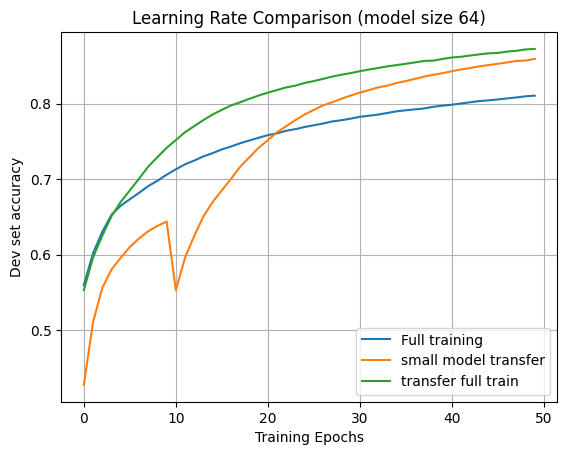

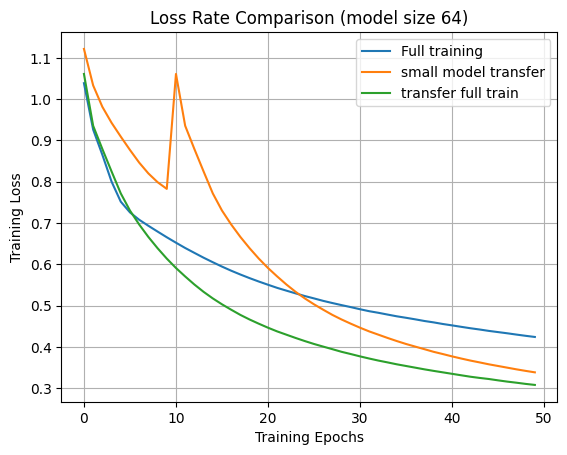

In [105]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)
# eigen_comparison(model_args)

CUDA Device used:  cuda


100%|██████████| 25/25 [43:21<00:00, 104.07s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 128, 'd_internal': 64, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9265419999999999	std: 0.021150052860454033
full train: 	0.8866700000000001	std: 0.04598526068209248
full transfer train: 	0.9327920000000001	std: 0.021158883146328872
Transfer train vs. Full train
p-value: 0.00033935445184374996
Statistically significant difference between models (p-value = 0.00033935445184374996 )
Effect size: 0.039871999999999796
Standardized Effect size (Cohen's d): 1.114027954174957
Transfer full train vs. Full train
p-value: 4.870603275639635e-05
Statistically significant difference between models (p-value = 4.870603275639635e-05 )
Effect size: 0.046121999999999996
Standardized Effect size (Cohen's d): 1.2885596752550565


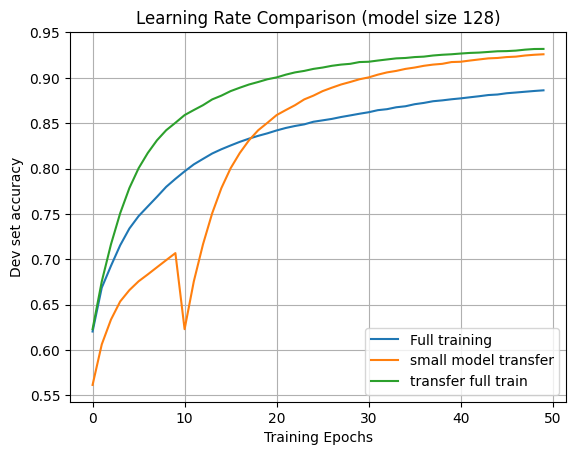

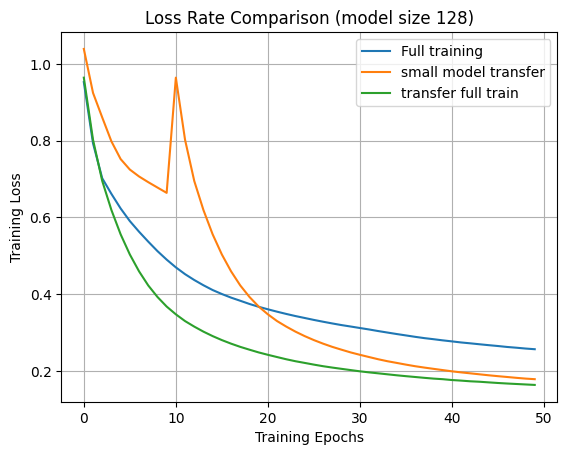

In [106]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)
# eigen_comparison(model_args)

CUDA Device used:  cuda


100%|██████████| 25/25 [1:21:26<00:00, 195.45s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9655879999999999	std: 0.012396316227008732
full train: 	0.914476	std: 0.04074299232997007
full transfer train: 	0.9711559999999999	std: 0.012624748076694435
Transfer train vs. Full train
p-value: 3.8265620206241076e-07
Statistically significant difference between models (p-value = 3.8265620206241076e-07 )
Effect size: 0.051111999999999935
Standardized Effect size (Cohen's d): 1.6973051382979236
Transfer full train vs. Full train
p-value: 4.152938760184114e-08
Statistically significant difference between models (p-value = 4.152938760184114e-08 )
Effect size: 0.05667999999999995
Standardized Effect size (Cohen's d): 1.8792460492591014


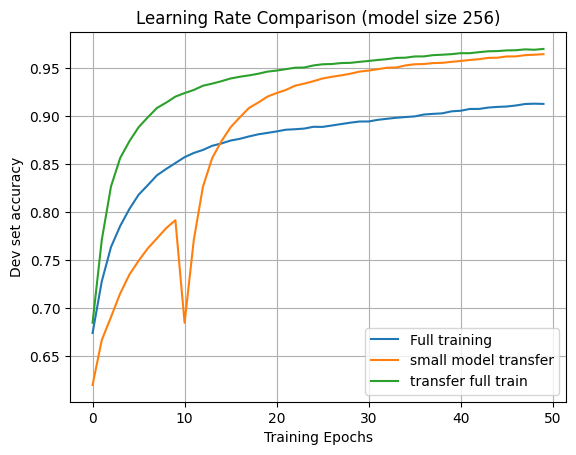

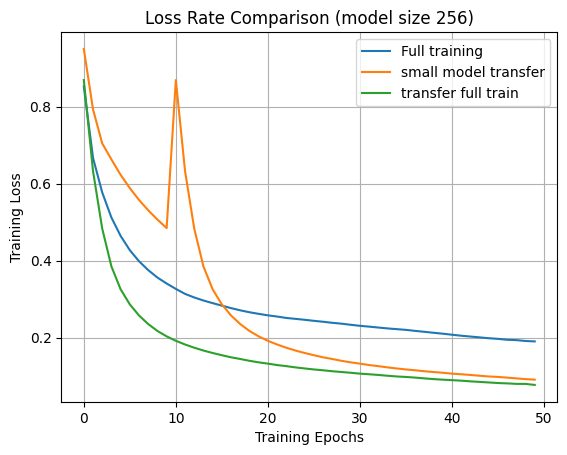

In [107]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)
# eigen_comparison(model_args)

CUDA Device used:  cuda


100%|██████████| 25/25 [2:54:33<00:00, 418.96s/it]  

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 512, 'd_internal': 256, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.983074	std: 0.004206949488643766
full train: 	0.928774	std: 0.035390442551626836
full transfer train: 	0.9861460000000001	std: 0.004555873571555723
Transfer train vs. Full train
p-value: 1.4346392113874897e-09
Statistically significant difference between models (p-value = 1.4346392113874897e-09 )
Effect size: 0.054300000000000015
Standardized Effect size (Cohen's d): 2.1546755145374488
Transfer full train vs. Full train
p-value: 3.3820608479998235e-10
Statistically significant difference between models (p-value = 3.3820608479998235e-10 )
Effect size: 0.05737200000000009
Standardized Effect size (Cohen's d): 2.273840259278138


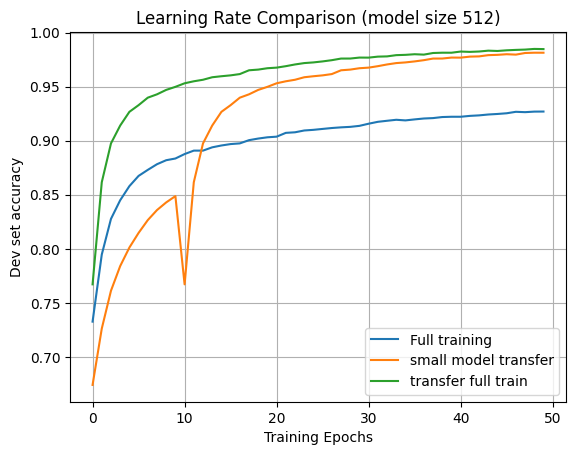

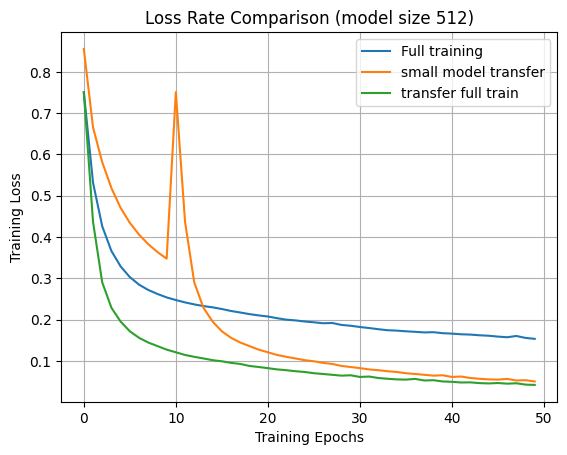

In [14]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)
# eigen_comparison(model_args)

CUDA Device used:  cuda


100%|██████████| 25/25 [8:15:08<00:00, 1188.33s/it]  

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 1024, 'd_internal': 512, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9861360000000002	std: 0.011333203607100687
full train: 	0.95327	std: 0.027588156879356764
full transfer train: 	0.9879339999999999	std: 0.011137241310127024
Transfer train vs. Full train
p-value: 2.0501105863297814e-06
Statistically significant difference between models (p-value = 2.0501105863297814e-06 )
Effect size: 0.032866000000000284
Standardized Effect size (Cohen's d): 1.5583936804167362
Transfer full train vs. Full train
p-value: 6.982301536687156e-07
Statistically significant difference between models (p-value = 6.982301536687156e-07 )
Effect size: 0.03466399999999992
Standardized Effect size (Cohen's d): 1.647731997859881


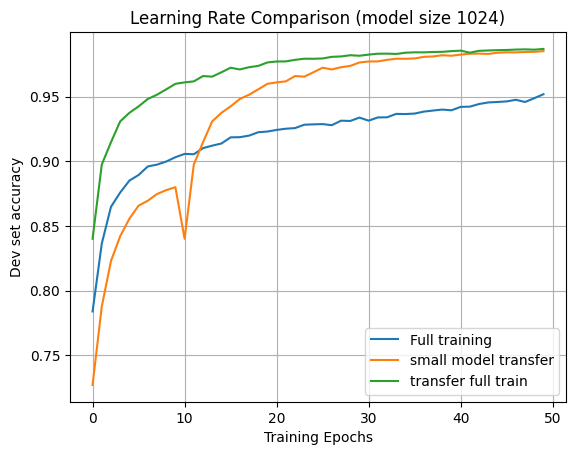

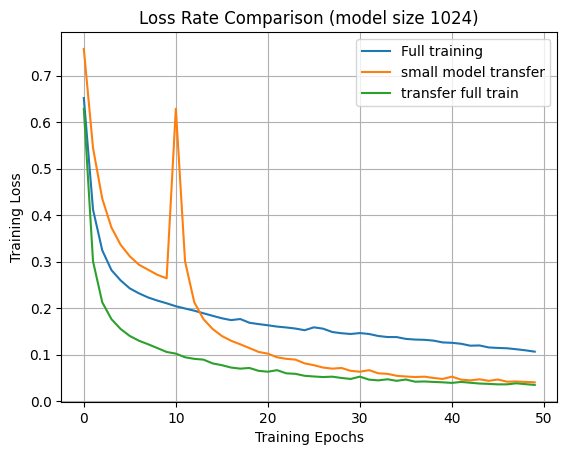

In [15]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)
# eigen_comparison(model_args)

In [28]:
def compare(model_args:List):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    transfer_ratio = 0.2

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for args in model_args:
        if prev_args == None:   
            prev_args = args
            continue
        res_std = []
        res_tran = []
        res_full_train = []
        
        for t in tqdm.tqdm(range(100)):
        # for t in range(10):
            # Small model for transfer
            model = Transformer(**prev_args).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))

            # Larger transfer model
            model_transfer = Transformer(**args).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer= training_loop(model_transfer, data, None, num_epochs=int(num_training_epochs*(1-transfer_ratio)))
            # res_tran.append(np.max(r2[:int(num_training_epochs*(1-transfer_ratio))]))
            res_tran.append(decode(model_transfer, dev)[-1])
            model_transfer = training_loop(model_transfer, data, None, num_epochs=int(num_training_epochs*transfer_ratio))
            res_full_train.append(decode(model_transfer, dev)[-1])

            # Full sized model no transfer
            model_full = Transformer(**args).to(DEVICE)
            m = training_loop(model_full, data, None, num_epochs=num_training_epochs)
            res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])

        
        prev_args = args

        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        print("full transfer train: \t{}\tstd: {}".format(np.average(res_full_train), np.std(res_full_train)))
        print("Transfer train vs. Full train")
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

        print("Transfer full train vs. Full train")
        t_stat, p_val = ttest_ind(res_full_train, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_full_train) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_full_train)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

 

In [29]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


100%|██████████| 100/100 [59:19<00:00, 35.60s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 64, 'd_internal': 32, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.8507795	std: 0.031034439816919526
full train: 	0.8235909999999999	std: 0.040294640698236774
full transfer train: 	0.8630609999999999	std: 0.03146147452043531
Transfer train vs. Full train
p-value: 2.80773121851486e-07
Statistically significant difference between models (p-value = 2.80773121851486e-07 )
Effect size: 0.02718850000000017
Standardized Effect size (Cohen's d): 0.7559956201857108
Transfer full train vs. Full train
p-value: 7.076310063670365e-13
Statistically significant difference between models (p-value = 7.076310063670365e-13 )
Effect size: 0.039470000000000005
Standardized Effect size (Cohen's d): 1.0918735117016252


In [30]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


100%|██████████| 100/100 [1:11:37<00:00, 42.97s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 128, 'd_internal': 64, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9282944999999998	std: 0.02279864019519585
full train: 	0.8792385	std: 0.04585013187276565
full transfer train: 	0.934127	std: 0.0230265959490325
Transfer train vs. Full train
p-value: 5.768060676273697e-18
Statistically significant difference between models (p-value = 5.768060676273697e-18 )
Effect size: 0.049055999999999766
Standardized Effect size (Cohen's d): 1.3548454116106512
Transfer full train vs. Full train
p-value: 3.2636560042499692e-21
Statistically significant difference between models (p-value = 3.2636560042499692e-21 )
Effect size: 0.05488850000000001
Standardized Effect size (Cohen's d): 1.5129186481476113


In [31]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


100%|██████████| 100/100 [2:48:42<00:00, 101.23s/it] 

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9659689999999999	std: 0.007583438468135678
full train: 	0.906478	std: 0.04183413696970454
full transfer train: 	0.971606	std: 0.007784883685707831
Transfer train vs. Full train
p-value: 3.5993388128765397e-31
Statistically significant difference between models (p-value = 3.5993388128765397e-31 )
Effect size: 0.05949099999999985
Standardized Effect size (Cohen's d): 1.9788581941960932
Transfer full train vs. Full train
p-value: 3.551980619582663e-35
Statistically significant difference between models (p-value = 3.551980619582663e-35 )
Effect size: 0.06512799999999996
Standardized Effect size (Cohen's d): 2.164509803337437


In [32]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


100%|██████████| 100/100 [8:32:29<00:00, 307.50s/it] 

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 512, 'd_internal': 256, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9799494999999999	std: 0.00989458815464292
full train: 	0.9294829999999998	std: 0.030604699165324267
full transfer train: 	0.9833005000000001	std: 0.009541196190729965
Transfer train vs. Full train
p-value: 2.4032872663858414e-36
Statistically significant difference between models (p-value = 2.4032872663858414e-36 )
Effect size: 0.05046650000000008
Standardized Effect size (Cohen's d): 2.2189235503603513
Transfer full train vs. Full train
p-value: 1.1571861847723678e-39
Statistically significant difference between models (p-value = 1.1571861847723678e-39 )
Effect size: 0.053817500000000296
Standardized Effect size (Cohen's d): 2.3741553595628617


In [33]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


100%|██████████| 100/100 [30:41:18<00:00, 1104.78s/it]  

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 1024, 'd_internal': 512, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9873490000000001	std: 0.008295260634844454
full train: 	0.9474215000000001	std: 0.028351777946894263
full transfer train: 	0.9887260000000001	std: 0.00838201789547123
Transfer train vs. Full train
p-value: 1.0268976725515411e-29
Statistically significant difference between models (p-value = 1.0268976725515411e-29 )
Effect size: 0.039927500000000005
Standardized Effect size (Cohen's d): 1.9114849652189136
Transfer full train vs. Full train
p-value: 4.197035624449201e-31
Statistically significant difference between models (p-value = 4.197035624449201e-31 )
Effect size: 0.041304499999999966
Standardized Effect size (Cohen's d): 1.9757700315514075


In [ ]:
def compare(model_args:List, transfer_ratio):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    transfer_ratio = 0.4

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for (i, args) in enumerate(model_args):
        if prev_args == None or i == 1:   
            prev_args = args
            continue

        res_std = []
        res_tran = []
        pprev_args = []
        transfer_train = []
        res_full_train = []
        full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(10)):
        # for t in range(10):
            # Small model for transfer
            model = Transformer(**model_args[0]).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            pprev_args.append(r1)
            loss1.append(l1)

            # Larger transfer model
            mt = Transformer(**prev_args).to(DEVICE)
            mt.extrap(model, method='onehot')
            model_transfer = Transformer(**args).to(DEVICE)
            model_transfer.extrap(mt, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_tran.append(np.max(r2[:int(num_training_epochs*(1-transfer_ratio))]))
            res_full_train.append(np.max(r2))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_train.append(r2[:int(num_training_epochs*(1-transfer_ratio))])
            transfer_full_train.append(r2)
            loss2.append(l2[:int(num_training_epochs*(1-transfer_ratio))])
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**args).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)


        
        pprev_args = average_on_axis(pprev_args)
        transfer_train = average_on_axis(transfer_train)
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss1 = average_on_axis(loss1)
        loss2 = average_on_axis(loss2)
        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)


        prev_args = args

        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        print("full transfer train: \t{}\tstd: {}".format(np.average(res_full_train), np.std(res_full_train)))
        print("Transfer train vs. Full train")
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

        print("Transfer full train vs. Full train")
        t_stat, p_val = ttest_ind(res_full_train, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Full training")
        ax.plot(axis_numbers, np.concatenate((pprev_args, transfer_train)), label='small model transfer')
        ax.plot(axis_numbers, transfer_full_train, label='transfer full train')
        ax.legend()
        ax.set_title("Learning Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Full training")
        ax.plot(axis_numbers, np.concatenate((loss1, loss2)), label='small model transfer')
        ax.plot(axis_numbers, loss4, label='transfer full train')
        ax.legend()
        ax.set_title("Loss Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # print(args)
        # print(results)
        print() 

double model extraption, starting with a model size of 256 and upscaling to 1024 because the 512 to 1024 seems to be somewhat near the ceiling of the model performance

The purpose is to experiment with another configuration

CUDA Device used:  cuda


100%|██████████| 10/10 [3:35:43<00:00, 1294.35s/it] 

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 1024, 'd_internal': 512, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9417199999999999	std: 0.02625486812002682
full train: 	0.94572	std: 0.034665517448900125
p-value: 0.7857281308211438
No statistically significant difference between models (p-value = 0.7857281308211438 )
Effect size: -0.004000000000000115
Standardized Effect size (Cohen's d): -0.13008504288617936


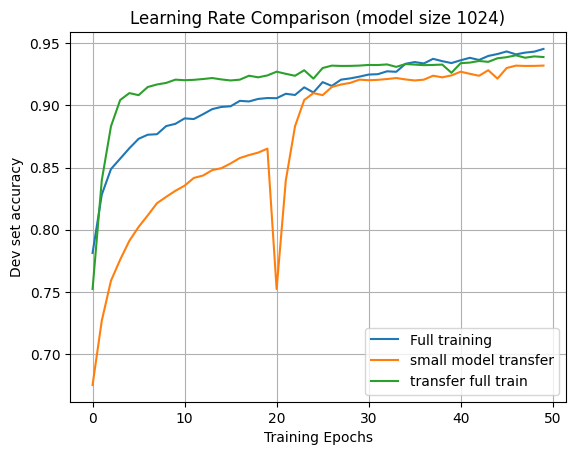

<Figure size 640x480 with 0 Axes>

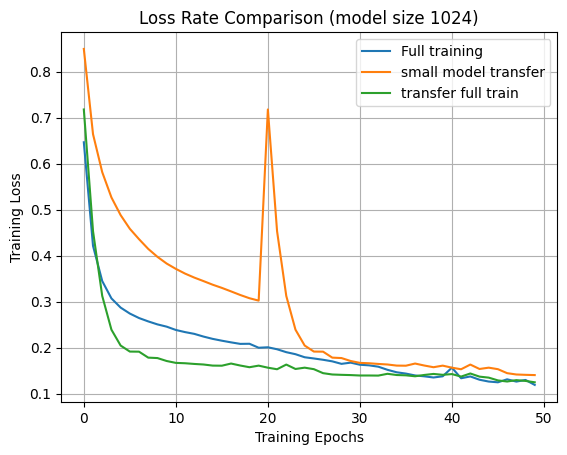

<Figure size 640x480 with 0 Axes>

In [ ]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

Next we try to do a gradual transfer starting at 128 and the doubling untill 30 epochs and then full training
- this seems too slow, the transfer lag (time it takes for the new model to gain a benefit from BUS) is too long


In [28]:
def compare(model_args:List):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    transfer_ratio = 15/50

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for (i, args) in enumerate(model_args):
        if prev_args == None or i != len(model_args)-1:   
            prev_args = args
            continue

        res_std = []
        res_tran = []
        pprev_args = []
        transfer_train = []
        full_train = []
        res_full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(25)):
        # for t in range(10):
            # Small model for transfer
            loss1.append([])
            pprev_args.append([])
            model = Transformer(**model_args[0]).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=5)
            pprev_args[t].extend(r1)
            loss1[t].extend(l1)

            ml = Transformer(**model_args[1]).to(DEVICE)
            ml.extrap(model, 'onehot')
            model, r1, l1 = training_loop(ml, data, dev, num_epochs=5)
            pprev_args[t].extend(r1)
            loss1[t].extend(l1)

            model = Transformer(**model_args[2]).to(DEVICE)
            model.extrap(ml, 'onehot')
            model, r1, l1 = training_loop(model, data, dev, num_epochs=5)
            pprev_args[t].extend(r1)
            loss1[t].extend(l1)

            # Larger transfer model
            # mt = Transformer(**prev_args).to(DEVICE)
            # mt.extrap(model, method='onehot')
            model_transfer = Transformer(**model_args[3]).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_full_train.append(np.max(r2))
            res_tran.append(np.max(r2[:int(num_training_epochs*(1-transfer_ratio))]))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_train.append(r2[:int(num_training_epochs*(1-transfer_ratio))])
            transfer_full_train.append(r2)
            loss2.append(l2[:int(num_training_epochs*(1-transfer_ratio))])
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**model_args[3]).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)


        pprev_args = average_on_axis(pprev_args)
        transfer_train = average_on_axis(transfer_train)
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss1 = average_on_axis(loss1)
        loss2 = average_on_axis(loss2)
        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)

        prev_args = args

        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        print("full transfer train: \t{}\tstd: {}".format(np.average(res_full_train), np.std(res_full_train)))
        print("Transfer train vs. Full train")
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

        print("Transfer full train vs. Full train")
        t_stat, p_val = ttest_ind(res_full_train, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_full_train) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_full_train)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Full training")
        ax.plot(axis_numbers, np.concatenate((pprev_args, transfer_train)), label='small model transfer')
        ax.plot(axis_numbers, transfer_full_train, label='transfer full train')
        ax.legend()
        ax.set_title("Learning Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Full training")
        ax.plot(axis_numbers, np.concatenate((loss1, loss2)), label='small model transfer')
        ax.plot(axis_numbers, loss4, label='transfer full train')
        ax.legend()
        ax.set_title("Loss Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # print(args)
        # print(results)
        print() 

CUDA Device used:  cuda


100%|██████████| 25/25 [42:20<00:00, 101.64s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 128, 'd_internal': 64, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.934272	std: 0.025594417672609778
full train: 	0.88319	std: 0.04114428757434014
full transfer train: 	0.9444019999999999	std: 0.02471042889146199
Transfer train vs. Full train
p-value: 4.59283524311776e-06
Statistically significant difference between models (p-value = 4.59283524311776e-06 )
Effect size: 0.05108199999999996
Standardized Effect size (Cohen's d): 1.49087293620651
Transfer full train vs. Full train
p-value: 1.0462787614188815e-07
Statistically significant difference between models (p-value = 1.0462787614188815e-07 )
Effect size: 0.06121199999999982
Standardized Effect size (Cohen's d): 1.8036881294553435


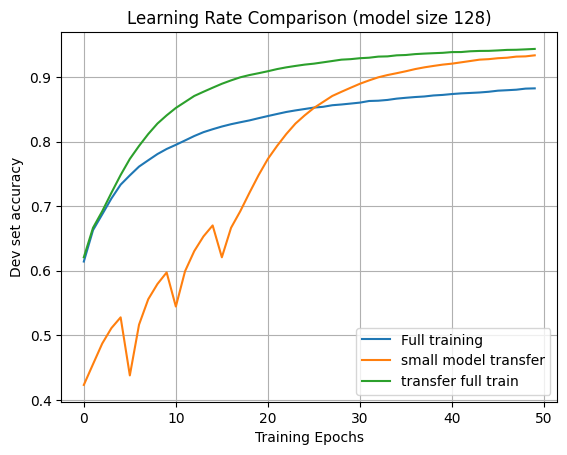

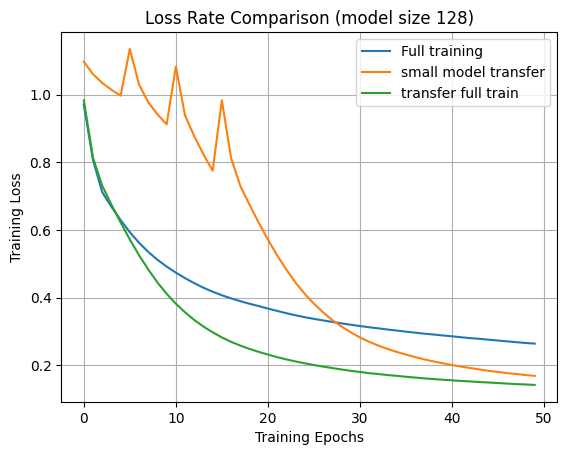

In [29]:
model_args = [
    {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


100%|██████████| 25/25 [2:54:19<00:00, 418.37s/it]  

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 512, 'd_internal': 256, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.96351	std: 0.01747489628009277
full train: 	0.939888	std: 0.02848732798982734
full transfer train: 	0.9697539999999999	std: 0.019093019247882193
Transfer train vs. Full train
p-value: 0.0011343673386395119
Statistically significant difference between models (p-value = 0.0011343673386395119 )
Effect size: 0.023622000000000032
Standardized Effect size (Cohen's d): 0.9995960827569274
Transfer full train vs. Full train
p-value: 9.282851331097154e-05
Statistically significant difference between models (p-value = 9.282851331097154e-05 )
Effect size: 0.029865999999999948
Standardized Effect size (Cohen's d): 1.231615777413468


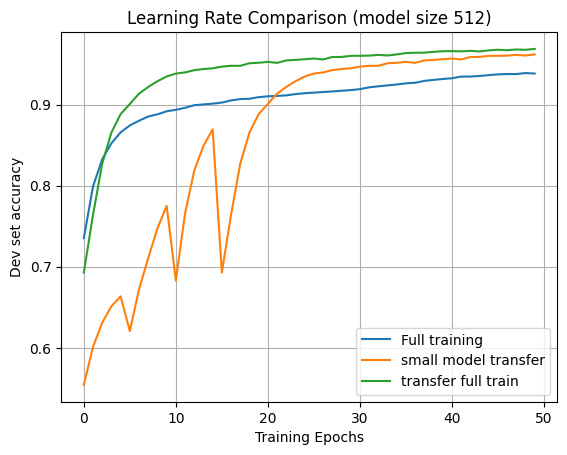

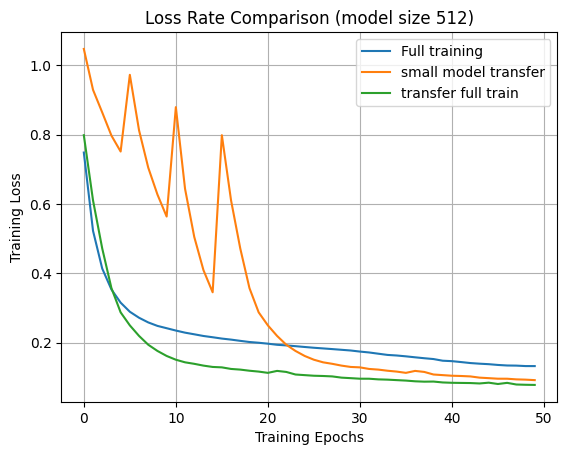

In [31]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

- same n/2 -> n model expansion but we transfer with sqrt of remaining epochs
- my prediction is that this will not perform as well

- additionally we are experimenting with the effect of transfer ratio on learning

In [34]:
def compare(model_args:List, transfer_ratio):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    # transfer_ratio = np.sqrt(num_training_epochs)/num_training_epochs

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for args in model_args:
        if prev_args == None:   
            prev_args = args
            continue
        res_std = []
        res_tran = []
        pprev_args = []
        res_full_train = []
        transfer_train = []
        full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(25)):
        # for t in range(10):
            # Small model for transfer
            model = Transformer(**prev_args).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            pprev_args.append(r1)
            loss1.append(l1)

            # Larger transfer model
            model_transfer = Transformer(**args).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_tran.append(np.max(r2[:int(num_training_epochs*(1-transfer_ratio))]))
            res_full_train.append(np.max(r2))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_train.append(r2[:int(num_training_epochs*(1-transfer_ratio))])
            transfer_full_train.append(r2)
            loss2.append(l2[:int(num_training_epochs*(1-transfer_ratio))])
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**args).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)


        
        pprev_args = average_on_axis(pprev_args)
        transfer_train = average_on_axis(transfer_train)
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss1 = average_on_axis(loss1)
        loss2 = average_on_axis(loss2)
        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)


        prev_args = args
        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        print("full transfer train: \t{}\tstd: {}".format(np.average(res_full_train), np.std(res_full_train)))
        print("Transfer train vs. Full train")
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

        print("Transfer full train vs. Full train")
        t_stat, p_val = ttest_ind(res_full_train, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_full_train) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_full_train)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Full training")
        ax.plot(axis_numbers, np.concatenate((pprev_args, transfer_train)), label='small model transfer')
        ax.plot(axis_numbers, transfer_full_train, label='transfer full train')
        ax.legend()
        ax.set_title("Learning Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Full training")
        ax.plot(axis_numbers, np.concatenate((loss1, loss2)), label='small model transfer')
        ax.plot(axis_numbers, loss4, label='transfer full train')
        ax.legend()
        ax.set_title("Loss Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # print(args)
        # print(results)
        print() 

CUDA Device used:  cuda


100%|██████████| 25/25 [1:10:53<00:00, 170.15s/it]


args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9666659999999999	std: 0.013516365783745272
full train: 	0.913642	std: 0.03877020422953689
full transfer train: 	0.96695	std: 0.01367195669975589
Transfer train vs. Full train
p-value: 7.93254557653549e-08
Statistically significant difference between models (p-value = 7.93254557653549e-08 )
Effect size: 0.05302399999999996
Standardized Effect size (Cohen's d): 1.8263405856939687
Transfer full train vs. Full train
p-value: 7.23902175133699e-08
Statistically significant difference between models (p-value = 7.23902175133699e-08 )
Effect size: 0.05330800000000002
Standardized Effect size (Cohen's d): 1.8338232062257191


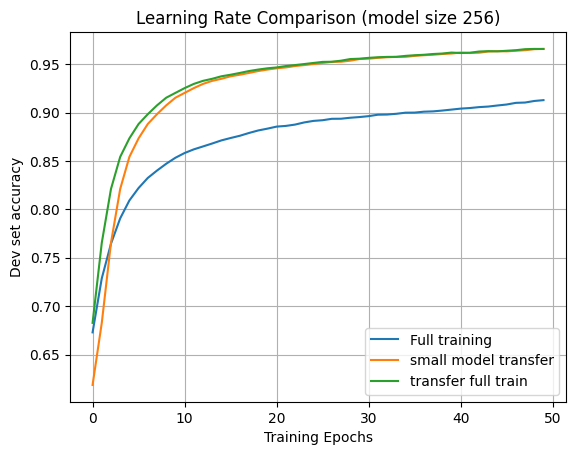

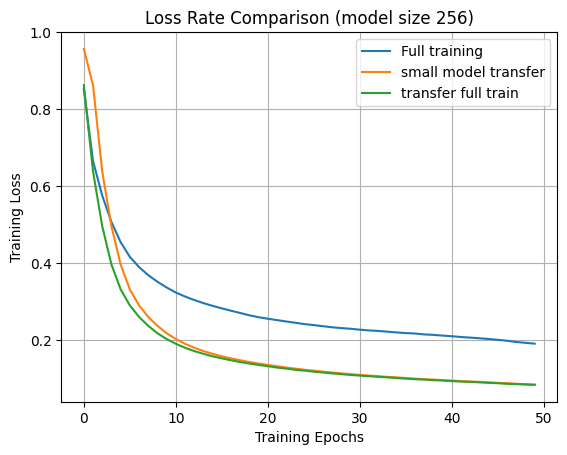

In [35]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args, 1/50)

In [36]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args, 3/50)

CUDA Device used:  cuda


 16%|█▌        | 4/25 [11:53<1:02:25, 178.35s/it]


KeyboardInterrupt: 

CUDA Device used:  cuda


100%|██████████| 25/25 [1:12:40<00:00, 174.42s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9674360000000002	std: 0.01196746021509994
full train: 	0.9276179999999999	std: 0.020868156986183523
p-value: 1.508741293089969e-10
Statistically significant difference between models (p-value = 1.508741293089969e-10 )
Effect size: 0.03981800000000024
Standardized Effect size (Cohen's d): 2.3408181107074673


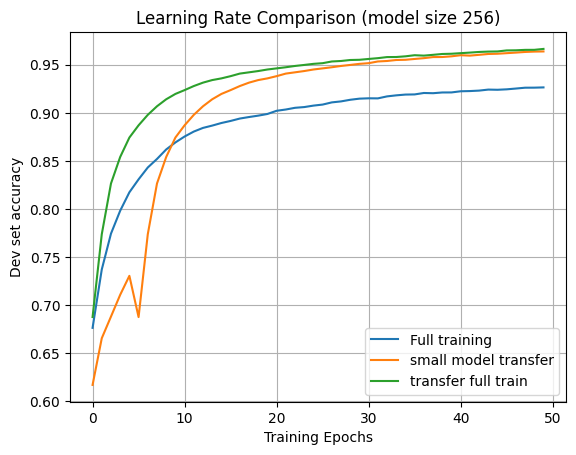

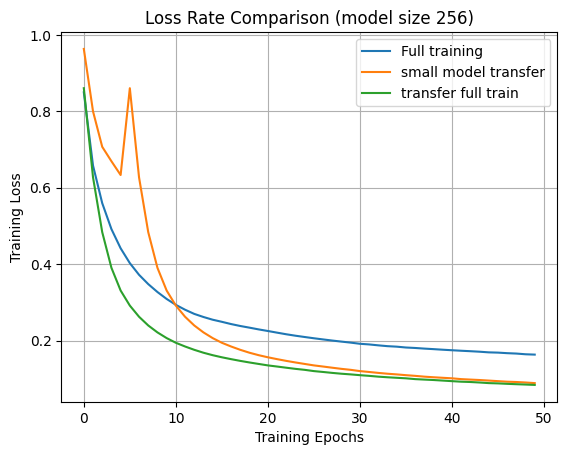

In [72]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args, 5/50)

100%|██████████| 25/25 [1:17:11<00:00, 185.25s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.969208	std: 0.012646657107710325
full train: 	0.8978959999999999	std: 0.037951866673458894
p-value: 1.7577519668116874e-11
Statistically significant difference between models (p-value = 1.7577519668116874e-11 )
Effect size: 0.07131200000000004
Standardized Effect size (Cohen's d): 2.5210376878102823


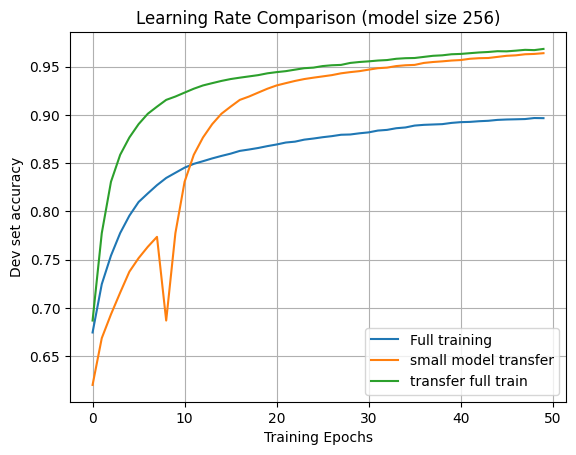

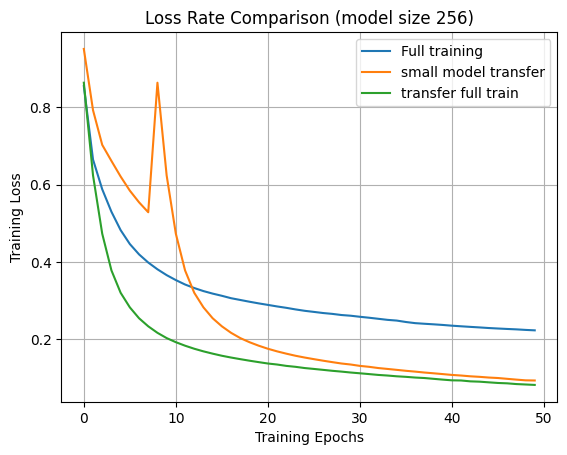

In [73]:
compare(model_args, 8/50)

100%|██████████| 25/25 [1:16:48<00:00, 184.36s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9739619999999999	std: 0.005870081430440291
full train: 	0.909548	std: 0.0358841036672229
p-value: 2.117878184292644e-11
Statistically significant difference between models (p-value = 2.117878184292644e-11 )
Effect size: 0.06441399999999986
Standardized Effect size (Cohen's d): 2.5052941271578026


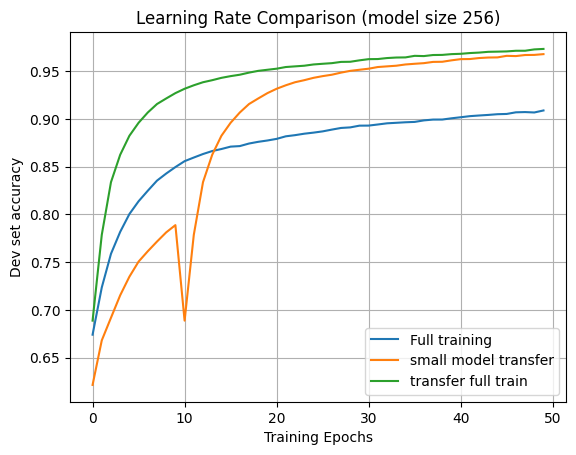

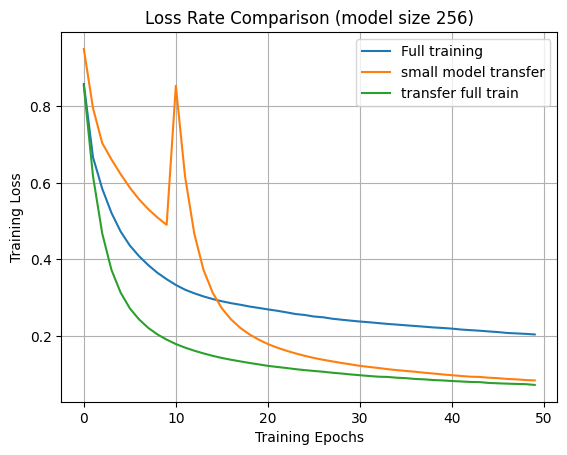

In [74]:
compare(model_args, 10/50)

100%|██████████| 25/25 [1:20:10<00:00, 192.43s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9716059999999999	std: 0.012418223061291813
full train: 	0.909324	std: 0.029996260166894138
p-value: 1.8552786778878367e-12
Statistically significant difference between models (p-value = 1.8552786778878367e-12 )
Effect size: 0.06228199999999984
Standardized Effect size (Cohen's d): 2.7130621210973973


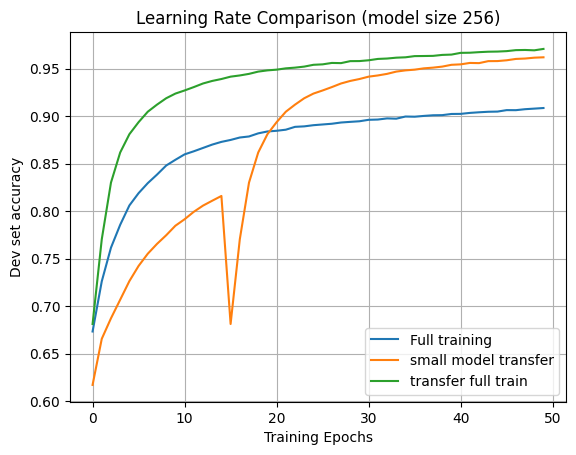

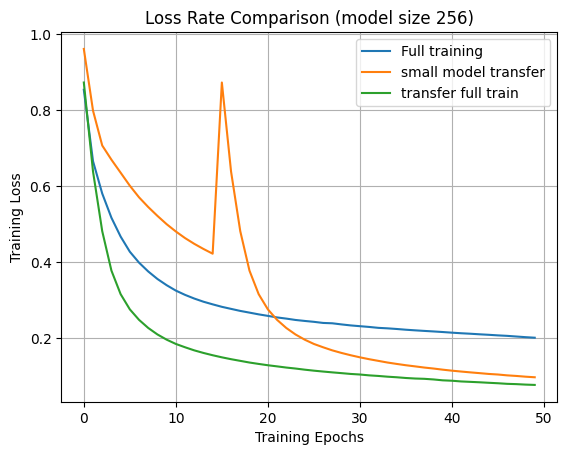

In [75]:
compare(model_args, 15/50)

100%|██████████| 25/25 [1:21:29<00:00, 195.58s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.971794	std: 0.010483437604144928
full train: 	0.9146740000000001	std: 0.034385206470224965
p-value: 4.670662460695525e-10
Statistically significant difference between models (p-value = 4.670662460695525e-10 )
Effect size: 0.05711999999999995
Standardized Effect size (Cohen's d): 2.2471433879353864


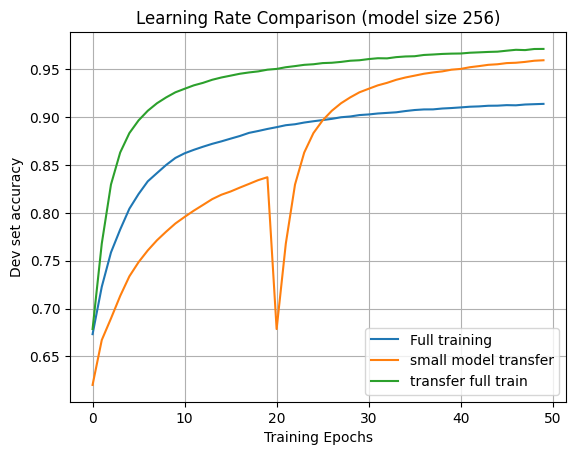

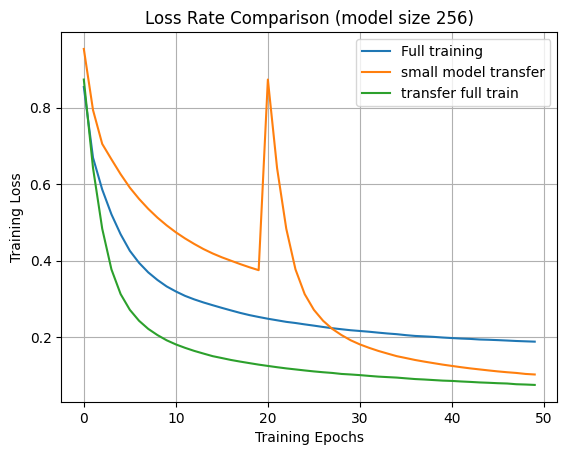

In [76]:
compare(model_args, 20/50)

100%|██████████| 25/25 [1:23:19<00:00, 200.00s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9718200000000001	std: 0.010182494782714106
full train: 	0.9104300000000001	std: 0.036005199624498684
p-value: 1.9317338131180627e-10
Statistically significant difference between models (p-value = 1.9317338131180627e-10 )
Effect size: 0.061390000000000056
Standardized Effect size (Cohen's d): 2.320276168899115


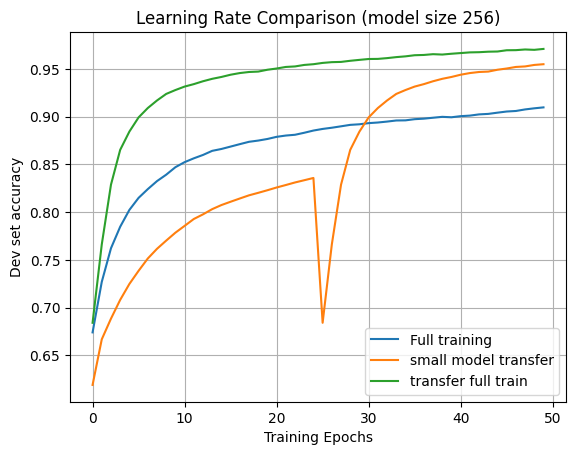

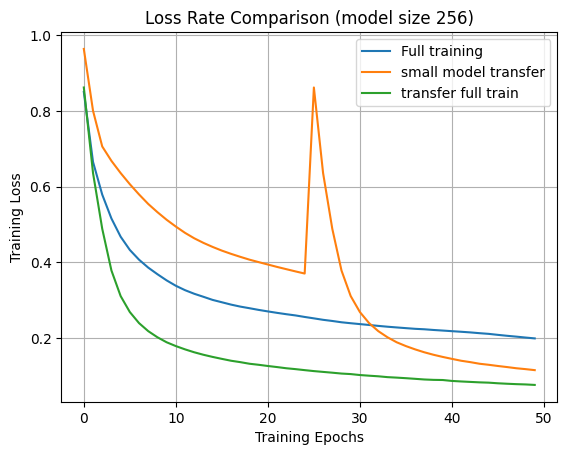

In [77]:
compare(model_args, 25/50)

100%|██████████| 25/25 [1:25:57<00:00, 206.30s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.973892	std: 0.007356394225434088
full train: 	0.900646	std: 0.039398053048342374
p-value: 8.313810500736868e-12
Statistically significant difference between models (p-value = 8.313810500736868e-12 )
Effect size: 0.07324600000000003
Standardized Effect size (Cohen's d): 2.584535223435314


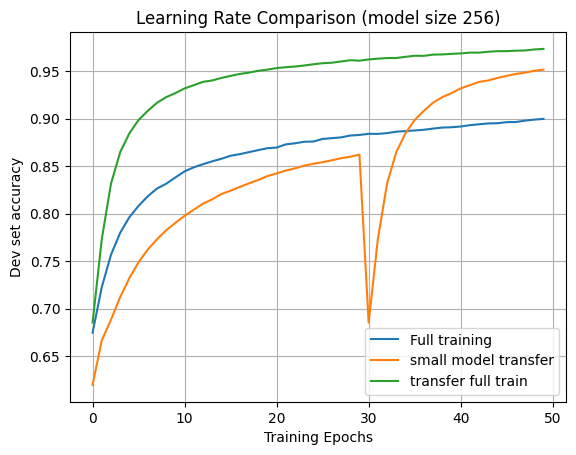

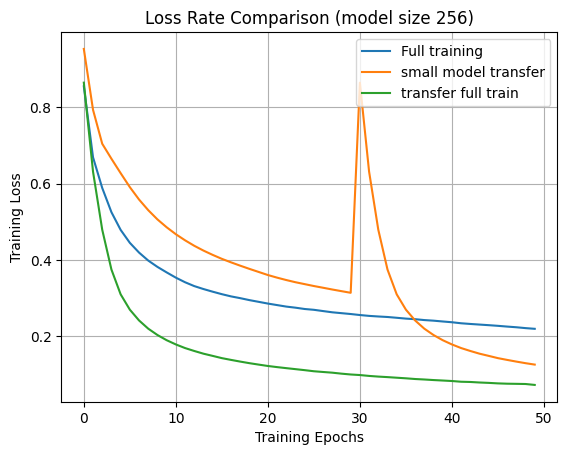

In [78]:
compare(model_args, 30/50)

100%|██████████| 25/25 [1:27:53<00:00, 210.92s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.969386	std: 0.02052388618171519
full train: 	0.912728	std: 0.03329202030517223
p-value: 5.220586287138737e-09
Statistically significant difference between models (p-value = 5.220586287138737e-09 )
Effect size: 0.056657999999999986
Standardized Effect size (Cohen's d): 2.0487498283017143


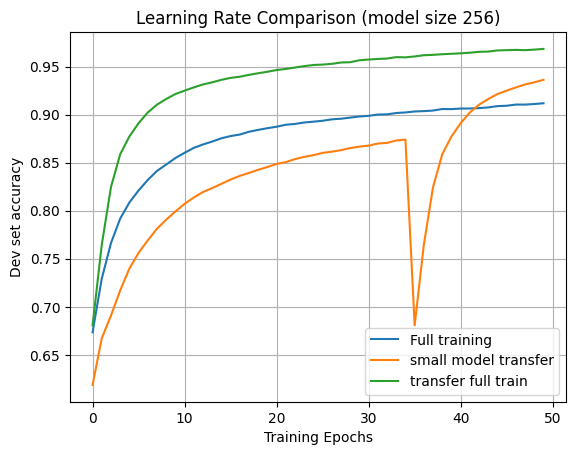

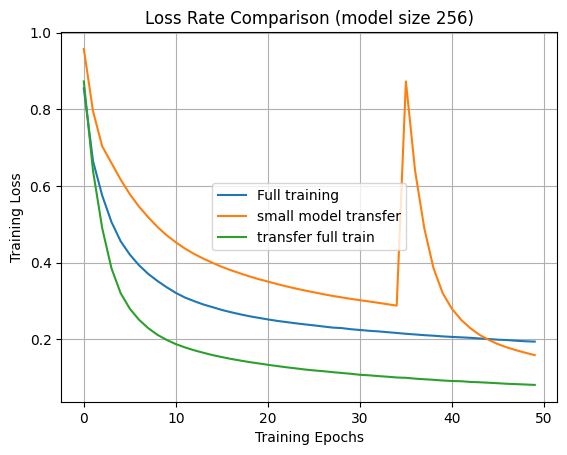

In [79]:
compare(model_args, 35/50)

100%|██████████| 25/25 [1:29:48<00:00, 215.55s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9682560000000001	std: 0.015008719598953144
full train: 	0.9021319999999998	std: 0.040000039699980304
p-value: 9.47224222475294e-10
Statistically significant difference between models (p-value = 9.47224222475294e-10 )
Effect size: 0.0661240000000003
Standardized Effect size (Cohen's d): 2.1888256580881316


ValueError: x and y must have same first dimension, but have shapes (50,) and (49,)

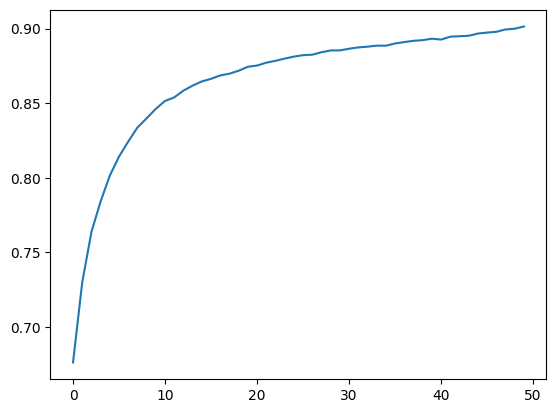

In [80]:
compare(model_args, 40/50)

In [ ]:
compare(model_args, 45/50)

control test to make sure that all the code is producing accurate results

In [39]:
def compare(model_args:List, transfer_ratio):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    # transfer_ratio = np.sqrt(num_training_epochs)/num_training_epochs

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for args in model_args:
        if prev_args == None:   
            prev_args = args
            continue
        res_std = []
        res_tran = []
        pprev_args = []
        transfer_train = []
        full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(25)):
        # for t in range(10):
            # Small model for transfer
            # model = Transformer(**prev_args).to(DEVICE)
            # model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            # pprev_args.append(r1)
            # loss1.append(l1)

            # Larger transfer model
            model_transfer = Transformer(**args).to(DEVICE)
            # model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_tran.append(np.max(r2))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_full_train.append(r2)
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**args).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)

            # Transfer training for remianing epochs for comparison
            # model_transfer = Transformer(**args).to(DEVICE)
            # model_transfer.extrap(model_transfer, method='onehot')
            # model_transfer, r4, l4 = training_loop(model_transfer, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            # transfer_full_train.append(r2+r4)
            # loss4.append(l2+l4)

        
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)


        prev_args = args

        print("args: ", args)
        
        print("Control 1: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("Control 2: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Control 1")
        ax.plot(axis_numbers, transfer_full_train, label='Control 2')
        ax.legend()
        ax.set_title("Learning Rate Comparison Control(model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Control 1")
        ax.plot(axis_numbers, loss4, label='Control 2')
        ax.legend()
        ax.set_title("Loss Rate Comparison Control (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # print(args)
        # print(results)
        print() 

100%|██████████| 25/25 [1:10:55<00:00, 170.24s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
Control 1: 	 0.9136180000000002	std: 0.030401437071296483
Control 2: 	0.9120820000000001	std: 0.03726230502800384
p-value: 0.8763178122441742
No statistically significant difference between models (p-value = 0.8763178122441742 )
Effect size: 0.0015360000000000928
Standardized Effect size (Cohen's d): 0.045169371896180796


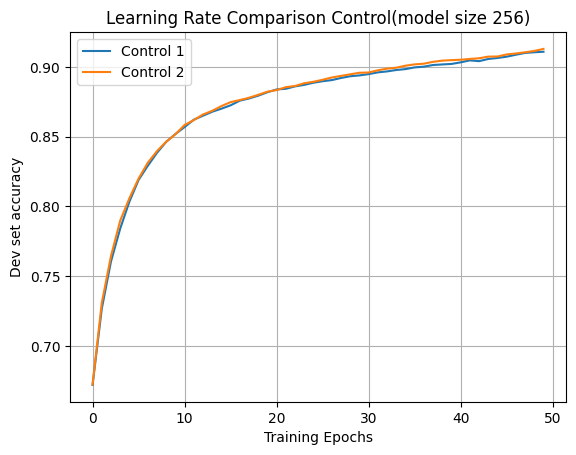

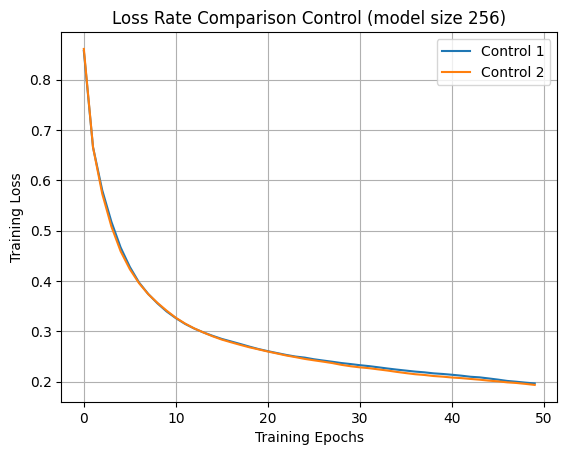

In [82]:
compare(model_args, 25/50)

In [72]:
def compare(model_args:List, transfer_ratio):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    # transfer_ratio = np.sqrt(num_training_epochs)/num_training_epochs

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for args in model_args:
        if prev_args == None:   
            prev_args = args
            continue
        res_std = []
        res_tran = []
        pprev_args = []
        transfer_train = []
        full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(25)):
        # for t in range(10):
            # Small model for transfer
            # model = Transformer(**prev_args).to(DEVICE)
            # model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            # pprev_args.append(r1)
            # loss1.append(l1)

            # Larger transfer model
            model_transfer = Transformer(**args, init=True).to(DEVICE)
            # model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_tran.append(np.max(r2))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_full_train.append(r2)
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**args).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)

            # Transfer training for remianing epochs for comparison
            # model_transfer = Transformer(**args).to(DEVICE)
            # model_transfer.extrap(model_transfer, method='onehot')
            # model_transfer, r4, l4 = training_loop(model_transfer, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            # transfer_full_train.append(r2+r4)
            # loss4.append(l2+l4)

        
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)


        prev_args = args

        print("args: ", args)
        
        print("Identity init: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("Standard init: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label='Standard init')
        ax.plot(axis_numbers, transfer_full_train, label="Identity init")
        ax.legend()
        ax.set_title("Learning Rate Comparison Control(model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label='Standard init')
        ax.plot(axis_numbers, loss4, label="Identity init")
        ax.legend()
        ax.set_title("Loss Rate Comparison Control (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # print(args)
        # print(results)
        print() 

- Testing to see if the models are learning faster because of some unknown feature of the upscaled matrices being mostly just an identity matrix

CUDA Device used:  cuda


100%|██████████| 25/25 [1:23:57<00:00, 201.48s/it]


args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 256, 'd_internal': 128, 'num_classes': 3, 'num_layers': 1}
Identity init: 	 0.9197059999999999	std: 0.06751559422829662
Standard init: 	0.91592	std: 0.039364006401787915
p-value: 0.8134157760454895
No statistically significant difference between models (p-value = 0.8134157760454895 )
Effect size: 0.003785999999999956
Standardized Effect size (Cohen's d): 0.06850942822893205


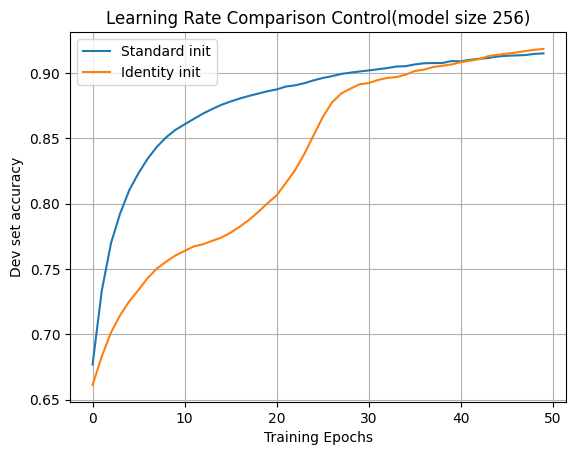

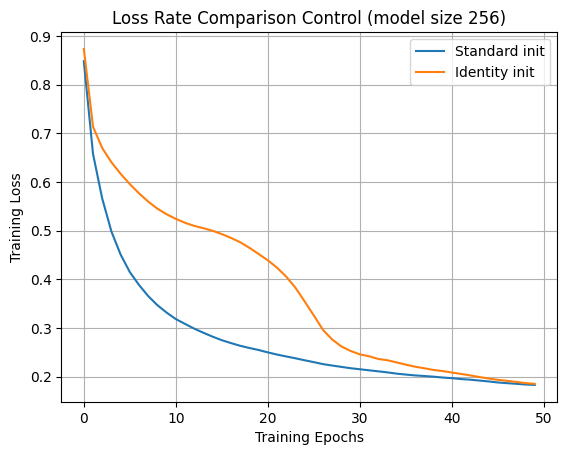

In [73]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positi':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args, 5/50)

Next, I will attempt a more gradual training technique.

The goal is to incrementally increase the model size

In [74]:
def compare(model_args:List):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    transfer_ratio = 15/50

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for (i, args) in enumerate(model_args):
        if prev_args == None or i != len(model_args)-1:   
            prev_args = args
            continue

        res_std = []
        res_tran = []
        pprev_args = []
        transfer_train = []
        full_train = []
        res_full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(10)):
        # for t in range(10):
            # Small model for transfer
            loss1.append([])
            pprev_args.append([])
            model = Transformer(**model_args[0]).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=5)
            pprev_args[t].extend(r1)
            loss1[t].extend(l1)

            ml = Transformer(**model_args[1]).to(DEVICE)
            ml.extrap(model, 'onehot')
            model, r1, l1 = training_loop(ml, data, dev, num_epochs=5)
            pprev_args[t].extend(r1)
            loss1[t].extend(l1)

            ml = Transformer(**model_args[2]).to(DEVICE)
            ml.extrap(model, 'onehot')
            model, r1, l1 = training_loop(ml, data, dev, num_epochs=5)
            pprev_args[t].extend(r1)
            loss1[t].extend(l1)

            # Larger transfer model
            # mt = Transformer(**prev_args).to(DEVICE)
            # mt.extrap(model, method='onehot')
            model_transfer = Transformer(**model_args[3]).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            # model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            res_full_train.append(np.max(r2))
            res_tran.append(np.max(r2[:int(num_training_epochs*(1-transfer_ratio))]))
            # res_tran.append(decode(model_transfer, dev)[-1])
            # res_tran.append(r2[-1])
            transfer_train.append(r2[:int(num_training_epochs*(1-transfer_ratio))])
            transfer_full_train.append(r2)
            loss2.append(l2[:int(num_training_epochs*(1-transfer_ratio))])
            loss4.append(l2)

            # Full sized model no transfer
            model_full = Transformer(**model_args[3]).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            # res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            max_r3 = np.max(r3)
            res_std.append(max_r3)
            # res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)


        pprev_args = average_on_axis(pprev_args)
        transfer_train = average_on_axis(transfer_train)
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss1 = average_on_axis(loss1)
        loss2 = average_on_axis(loss2)
        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)

        prev_args = args

        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        print("full transfer train: \t{}\tstd: {}".format(np.average(res_full_train), np.std(res_full_train)))
        print("Transfer train vs. Full train")
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)

        print("Transfer full train vs. Full train")
        t_stat, p_val = ttest_ind(res_full_train, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Standardized Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Full training")
        ax.plot(axis_numbers, np.concatenate((pprev_args, transfer_train)), label='small model transfer')
        ax.plot(axis_numbers, transfer_full_train, label='transfer full train')
        ax.legend()
        ax.set_title("Learning Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Full training")
        ax.plot(axis_numbers, np.concatenate((loss1, loss2)), label='small model transfer')
        ax.plot(axis_numbers, loss4, label='transfer full train')
        ax.legend()
        ax.set_title("Loss Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        # print(args)
        # print(results)
        print() 

CUDA Device used:  cuda


100%|██████████| 10/10 [16:29<00:00, 98.92s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 128, 'd_internal': 64, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9317399999999999	std: 0.03409917007787725
full train: 	0.87335	std: 0.034985361224374976
full transfer train: 	0.9418799999999999	std: 0.03328067156774332
Transfer train vs. Full train
p-value: 0.0021139723098591817
Statistically significant difference between models (p-value = 0.0021139723098591817 )
Effect size: 0.05838999999999994
Standardized Effect size (Cohen's d): 1.6902538240326168
Transfer full train vs. Full train
p-value: 0.0004734826166430681
Statistically significant difference between models (p-value = 0.0004734826166430681 )
Effect size: 0.05838999999999994
Standardized Effect size (Cohen's d): 1.6902538240326168


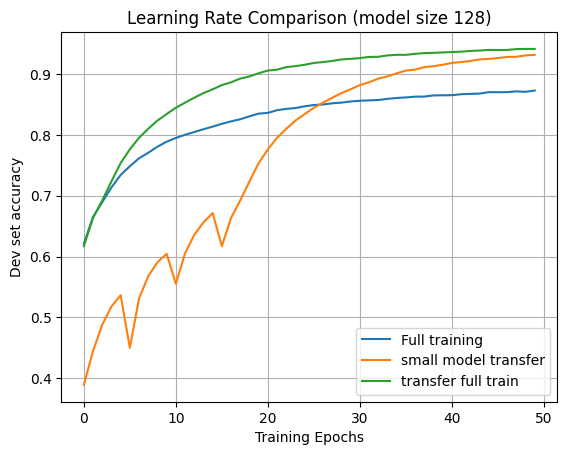

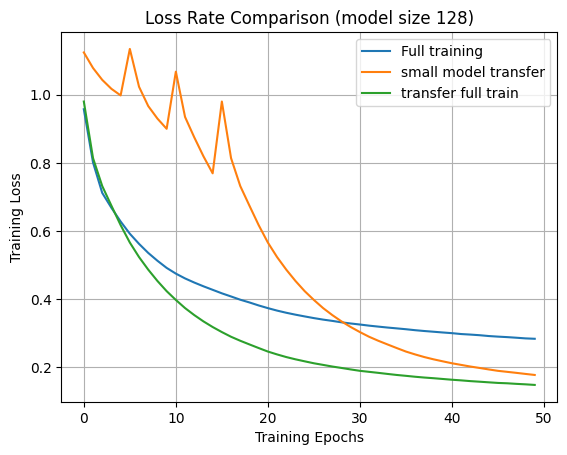

In [23]:
model_args = [
    {'vocab_size':27, 'num_positions':20, 'd_model':16, 'd_internal':8, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    {'vocab_size':27, 'num_positions':20, 'd_model':32, 'd_internal':16, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':64, 'd_internal':32, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

In [78]:
model_args = [
    {'vocab_size':27, 'num_positions':20, 'd_model':60, 'd_internal':30, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    {'vocab_size':27, 'num_positions':20, 'd_model':80, 'd_internal':40, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':100, 'd_internal':50, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':128, 'd_internal':64, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':256, 'd_internal':128, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':512, 'd_internal':256, 'num_classes':3, 'num_layers':1},
    # {'vocab_size':27, 'num_positions':20, 'd_model':1024, 'd_internal':512, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)

CUDA Device used:  cuda


  0%|          | 0/10 [00:03<?, ?it/s]

torch.Size([40, 60])
torch.Size([20, 20])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 20 for tensor number 1 in the list.